# Part 1: Scrape Wikipedia for Canada postal codes

## Download dependencies

In [2]:
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge lxml --yes

from bs4 import BeautifulSoup
import requests

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forg

In [3]:
import pandas as pd

## Get the data from Wikipedia

In [4]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

soup = BeautifulSoup(source,"lxml")

table = soup.table

#get headers from wikipedia table
headers = table.find_all("th") 

#below: create a list of the rows of the wikipedia table (each row is again a list)
rows_body = table.tbody.find_all("tr")
rows_list =[]
for row in rows_body:
    temp_list = []
    entries = row.find_all("td")
    for entry in entries:
        temp_list.append(entry.text.replace("\n",""))
    if temp_list:
        rows_list.append(temp_list)

#construct dataframe
df_canada = pd.DataFrame(rows_list,columns = [head.text.replace("\n","") for head in headers])
df_canada

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
...,...,...,...
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West
285,M8Z,Etobicoke,South of Bloor


## Clean up dataframe

In [5]:
#check the amount of entries with Borough "Not assigned"
print("There are {} entries in the dataframe with a borough that is 'Not assigned'.\nAfter removal of these entries {} should remain".format(df_canada["Borough"].value_counts()["Not assigned"] , df_canada.shape[0]-df_canada["Borough"].value_counts()["Not assigned"])) 

#Change "postcode" header to "PostalCode"
df_canada.columns = ["PostalCode" , "Borough" , "Neighborhood"]

#drop rows with Borough "Not assigned"
df_can = df_canada.drop(df_canada[df_canada["Borough"] == "Not assigned"].index).reset_index(drop = True)
df_can

There are 77 entries in the dataframe with a borough that is 'Not assigned'.
After removal of these entries 210 should remain


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
...,...,...,...
205,M8Z,Etobicoke,Kingsway Park South West
206,M8Z,Etobicoke,Mimico NW
207,M8Z,Etobicoke,The Queensway West
208,M8Z,Etobicoke,Royal York South West


In [6]:
#define function to join strings in a list, without duplicates
def unique_join(to_join):
    return ", ".join(set(to_join))

In [7]:
#new dataframe: PostalCode with the Borough associated to PostalCode
df_can_grouped1 = df_can.groupby("PostalCode")["Borough"].apply(unique_join).reset_index()
#new dataframe: PostalCode with the associated Neighborhoods to PostalCode
df_can_grouped2 = df_can.groupby("PostalCode")["Neighborhood"].apply(unique_join).reset_index()

#Merge the dataframes above on PostalCode
df_can_post = df_can_grouped1.merge(df_can_grouped2 , on="PostalCode")
df_can_post

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Morningside, Guildwood, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Richview Gardens, Kingsview Village, St. Phill..."
101,M9V,Etobicoke,"Mount Olive, South Steeles, Thistletown, Silve..."


In [8]:
#Indices where Neighborhood is "Not assigned"
NA_list = df_can_post[["not assigned" in x.lower() for x in df_can_post["Neighborhood"]]].index

#Replace Not assigned with name of Borough
df_can_post.loc[NA_list , "Neighborhood"] = df_can_post.loc[NA_list , "Borough"]

In [9]:
print("The dataframe 'df_can_post' has {} rows".format(df_can_post.shape[0]))

The dataframe 'df_can_post' has 103 rows


# Part 2: Get coordinates for dataframe

## Download dependencies

In [121]:
#!conda install -c conda-forge geocoder --yes
#import geocoder
#print("It's good")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    future-0.18.2              |           py36_0         713 KB  conda-forge
    click-7.0                  |             py_0          61 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         833 KB

The following NEW packages will be INSTALLED:

    future:   0.18.2-py36_0 conda-

## Add coordinates to dataframe
Getting the coordinates using Geocoder package did not work for me, I thus used the csv file with coordinates

In [10]:
#Read csv file into dataframe
df_ll = pd.read_csv("Geospatial_Coordinates.csv")

#Rename column to match earlier dataframe
df_ll.rename(columns = {"Postal Code" : "PostalCode"},inplace =True)

#Merge dataframes to add coordinates
df_can_pll = df_can_post.merge(df_ll , on = "PostalCode")
df_can_pll

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Morningside, Guildwood, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Richview Gardens, Kingsview Village, St. Phill...",43.688905,-79.554724
101,M9V,Etobicoke,"Mount Olive, South Steeles, Thistletown, Silve...",43.739416,-79.588437


# Part 3: Clustering

## Download dependencies and set options

In [11]:
pd.set_option('display.max_columns', None)

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance #measure distance between coordinates

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          91 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.50   | 3

## Get distances between postcodes
I noticed that some postcodes were closer to each other than other ones. Using a fixed radius for finding venues in the Foursquare API would thus lead to overlapping search areas for different postcodes. In the cells below, the distance between a postcode and its nearest neighbor is found, half of this distance will then be used later on in the API, this leads to non-overlapping search areas, although some search radii will be rather small.

In [12]:
#Number of postcodes
nr_postcodes = df_can_pll.shape[0]

#Create matrix with distane between all coordinates
distance_matrix = np.empty((nr_postcodes , nr_postcodes))
for i in range(nr_postcodes):
    for j in range(nr_postcodes):
        distance_matrix[i,j] = geopy.distance.distance((df_can_pll.loc[i,'Latitude'], df_can_pll.loc[i,'Longitude']),(df_can_pll.loc[j,'Latitude'], df_can_pll.loc[j,'Longitude'])).m

In [13]:
#Find the closest neighbor for all postcodes
min_distance_list = []
for i in range(nr_postcodes):
    min_distance_list.append(np.min(distance_matrix[i,:][np.nonzero(distance_matrix[i,:])]))
    
df_can_pll["Nearest_distance"] = min_distance_list
df_can_pll

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Nearest_distance
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3394.463761
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,3253.396652
2,M1E,Scarborough,"Morningside, Guildwood, West Hill",43.763573,-79.188711,2416.096726
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1831.813623
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1831.813623
...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,1630.695041
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,1630.695041
100,M9R,Etobicoke,"Richview Gardens, Kingsview Village, St. Phill...",43.688905,-79.554724,1990.868552
101,M9V,Etobicoke,"Mount Olive, South Steeles, Thistletown, Silve...",43.739416,-79.588437,2607.094886


In the following cells, a map of Toronto is drawn, with the area indicated where I will search for venues later on.

In [14]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, postcode, r in zip(df_can_pll['Latitude'], df_can_pll['Longitude'], df_can_pll['Borough'], df_can_pll['Neighborhood'], df_can_pll["PostalCode"], df_can_pll["Nearest_distance"]):
    label = '{}; Borough: {}; Neighborhoods: {}'.format(postcode, borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Circle( #Circle instead of CircleMaker to give it a fixed radius in meters
        [lat, lng],
        radius=r/2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Define parameters for Foursquare API

In [16]:
CLIENT_ID = 'K01FZFOYVCMZ5N2HETZPNWXLKNHIVZKHCCF1AKTAVIY4ZLXX' # your Foursquare ID
CLIENT_SECRET = 'KCLVJ3ROCHHXIINQDMIRUFBTL2I0VJSTJPUIJO2I4RPOYMZ5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K01FZFOYVCMZ5N2HETZPNWXLKNHIVZKHCCF1AKTAVIY4ZLXX
CLIENT_SECRET:KCLVJ3ROCHHXIINQDMIRUFBTL2I0VJSTJPUIJO2I4RPOYMZ5


## Prepare a dataframe for clustering
Using the Foursquare API, venues around each postcode will be found.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

When getting the venues, I noticed there was one postcode not getting any venues returned for the defined search radius. In the below code, when no venues are returned for a postcode, one venue is created with name "Nothing to see here" and category "Boring".

In [18]:
def getNearbyVenues(postcodes, latitudes, longitudes, radii):
    
    venues_list=[]
    for code, lat, lng, r in zip(postcodes, latitudes, longitudes, radii):
        #print(code)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            r/2, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        if results:
            venues_list.append([(
                code, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        else:
            venues_list.append([(
            code,
            lat,
            lng,
            "Nothing to see here",
            lat,
            lng,
            "Boring")])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
Toronto_venues = getNearbyVenues(df_can_pll["PostalCode"], df_can_pll["Latitude"], df_can_pll["Longitude"], df_can_pll["Nearest_distance"])
Toronto_venues

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
2,M1B,43.806686,-79.194353,Penguin Exhibit,43.819435,-79.185959,Zoo Exhibit
3,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
4,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
...,...,...,...,...,...,...,...
3354,M9W,43.706748,-79.594054,New York Fries,43.719974,-79.600815,Fast Food Restaurant
3355,M9W,43.706748,-79.594054,Zaza Shawarma,43.719994,-79.600826,Yoga Studio
3356,M9W,43.706748,-79.594054,Up Express On Board,43.705147,-79.613496,Moving Target
3357,M9W,43.706748,-79.594054,Dollarama,43.720259,-79.600361,Discount Store


Now that the venues are found, a dataframe that can be used for clustering will be prepared.

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['PostalCode'] = Toronto_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boring,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Pla

In [21]:
toronto_grouped = toronto_onehot.groupby("PostalCode").mean().reset_index()
toronto_grouped

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boring,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Pla

## Starting the clustering

Before starting the clustering step, I try to find a good choice for the number of clusters. For this the distance of all points (postcodes) to the centroids is measured (distance is here euclidean distance between 333-tuples) and averaged. The value where an "elbow" point is seen, is then taken as number of clusters.

In [22]:
#Find, for number of clusters between 1 and 20, the mean centroid distance
toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

mean_centroid_distances = []

for k in range(1,21):
    kmeans = KMeans(n_clusters=k , n_init = 20).fit(toronto_grouped_clustering)
    mean_centroid_distances.append((k,np.mean([np.linalg.norm(np.array(toronto_grouped_clustering.iloc[j,:]) - kmeans.cluster_centers_[kmeans.labels_[j]]) for j in range(toronto_grouped_clustering.shape[0])])))

mean_centroid_distances

[(1, 0.25875804609266034),
 (2, 0.2488615279950781),
 (3, 0.23741736460507712),
 (4, 0.23252721006586963),
 (5, 0.2265281503779158),
 (6, 0.22183108328938742),
 (7, 0.21713040453864962),
 (8, 0.21017717231548783),
 (9, 0.20789703274294954),
 (10, 0.20131253528004578),
 (11, 0.19781716025905244),
 (12, 0.1954379802442753),
 (13, 0.19194940999037025),
 (14, 0.18546949047162412),
 (15, 0.18262529005238515),
 (16, 0.17930993101172776),
 (17, 0.17818015475066049),
 (18, 0.17125351563152835),
 (19, 0.16658000448878463),
 (20, 0.16418897373920335)]

In [23]:
x = [ z[0] for z in mean_centroid_distances]
y = [ z[1] for z in mean_centroid_distances]

In [24]:
import matplotlib.pyplot as plt

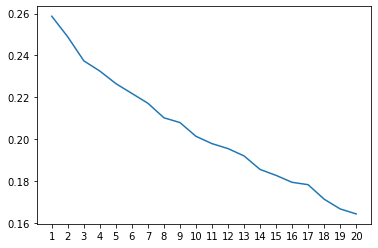

In [26]:
plt.plot(x,y)
plt.xticks(np.arange(1, 21))
plt.show()

While there is not a very clear "elbow point" (to me), I have chosen to take 3 clusters. In the cell below, the labels are generated, using three clusters.

In [27]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

[2 0 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2]


For further investigation, we associate to each postcode the top 5 venue categories.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcodes_venues_sorted = pd.DataFrame(columns=columns)
postcodes_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postcodes_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Zoo Exhibit,Fast Food Restaurant,Pizza Place,American Restaurant,Coffee Shop
1,M1C,Park,Breakfast Spot,Italian Restaurant,Neighborhood,Burger Joint
2,M1E,Pizza Place,Coffee Shop,Fast Food Restaurant,Pharmacy,Park
3,M1G,Coffee Shop,Park,Pharmacy,Zoo Exhibit,Eastern European Restaurant
4,M1H,Bakery,Coffee Shop,Indian Restaurant,Sporting Goods Shop,Burger Joint


We also add the cluster together with some other information.

In [30]:
# add clustering labels
postcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_can_pll.drop(["Nearest_distance"],axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(postcodes_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2,Zoo Exhibit,Fast Food Restaurant,Pizza Place,American Restaurant,Coffee Shop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Park,Breakfast Spot,Italian Restaurant,Neighborhood,Burger Joint
2,M1E,Scarborough,"Morningside, Guildwood, West Hill",43.763573,-79.188711,2,Pizza Place,Coffee Shop,Fast Food Restaurant,Pharmacy,Park
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Park,Pharmacy,Zoo Exhibit,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Bakery,Coffee Shop,Indian Restaurant,Sporting Goods Shop,Burger Joint


Finally, a map is drawn with each postcode colored along the cluster it is in.

In [31]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the tables below, the postcodes are grouped along their cluster labels, with the top 5 venues displayed.

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,M1C,0,Park,Breakfast Spot,Italian Restaurant,Neighborhood,Burger Joint
3,M1G,0,Coffee Shop,Park,Pharmacy,Zoo Exhibit,Eastern European Restaurant
9,M1N,0,Park,Fast Food Restaurant,Gym,Café,General Entertainment
20,M2L,0,Park,Pool,Coffee Shop,Zoo Exhibit,Electronics Store
45,M4P,0,Food & Drink Shop,Breakfast Spot,Convenience Store,Clothing Store,Hotel
48,M4T,0,Park,Tennis Court,Playground,Gym,Zoo Exhibit
50,M4W,0,Park,Trail,Playground,Zoo Exhibit,Eastern European Restaurant
64,M5P,0,Jewelry Store,Trail,Gym / Fitness Center,Park,Sushi Restaurant
79,M6L,0,Convenience Store,Park,Karaoke Bar,Bakery,Electronics Store
91,M8Y,0,Italian Restaurant,Park,Eastern European Restaurant,Shopping Mall,Gym / Fitness Center


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
56,M5E,1,Boring,Dive Bar,Doner Restaurant,Dongbei Restaurant,Donut Shop


Explanation for the above table: Since this postcode has "Boring" as most common venue, we know (due to how the function for getting venues was defined) that there were actually no venues returned for this postcode.

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,2,Zoo Exhibit,Fast Food Restaurant,Pizza Place,American Restaurant,Coffee Shop
2,M1E,2,Pizza Place,Coffee Shop,Fast Food Restaurant,Pharmacy,Park
4,M1H,2,Bakery,Coffee Shop,Indian Restaurant,Sporting Goods Shop,Burger Joint
5,M1J,2,Sandwich Place,Fast Food Restaurant,Pharmacy,Grocery Store,Liquor Store
6,M1K,2,Discount Store,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place
...,...,...,...,...,...,...,...
98,M9N,2,Pharmacy,Pizza Place,Diner,Fried Chicken Joint,Café
99,M9P,2,Pizza Place,Sandwich Place,Intersection,Chinese Restaurant,Ice Cream Shop
100,M9R,2,Pharmacy,American Restaurant,Bus Line,Supplement Shop,Chinese Restaurant
101,M9V,2,Pizza Place,Grocery Store,Coffee Shop,Bus Line,Caribbean Restaurant
